# Semi-Supervised VAE Project
## By VAEGen

## Setup

### Import libraries

In [1]:
import os
import time
import torch
import argparse
from functools import reduce
# 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plt

from collections import defaultdict

# Torch
import torch
from torch.distributions import Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

# Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

### Meta parameters

In [2]:
batch_size=32*8*2
epochs=5
learning_rate=1e-3
latent_dim = 25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print layers, used for debugging
NNprint_ = False
classes=[0,1,2,3,4]
num_classes=len(classes)
file='fashioncvae.torch'

### Import MNIST Dataset

In [3]:
# transforms arrays into tensors, can be extended
transformations = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Lambda(lambda p: Bernoulli(probs=p).sample())])

# define the train and test sets
dset_train = MNIST(root='data', train=True,  transform=transformations, download=True)
dset_test  = MNIST(root='data', train=False, transform=transformations)

def stratified_sampler(labels,classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets,classes))
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.targets,classes))

### Import FashionMNIST Dataset

In [4]:
train = FashionMNIST(
    root='data', train=True, transform=transforms.ToTensor(),
    download=True)
test= FashionMNIST(
    root='data', train=False, transform=transforms.ToTensor(),
    download=False)

### Configure Loaders

In [5]:
train_loader = torch.utils.data.DataLoader(
  train,
  batch_size=batch_size,sampler=stratified_sampler(train.targets,classes))

test_loader = torch.utils.data.DataLoader(
  test,
  batch_size=batch_size,sampler=stratified_sampler(test.targets,classes))

### Plot examples

In [6]:

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
def plot_examples(model=None,sample=False,data=None):
    if data is None:
        if (model==None):
            batch_idx, (data, example_targets) = next(examples)
        else:
            batch_idx, (data, example_targets) = next(examples)
            if sample:
                zeros=torch.zeros(10,1024)
                samples= torch.cat((torch.rand(32,1024),zeros)).T
                data = model.sample(samples.to(device))
            else:
                data = model(data.to(device),example_targets)[0]
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.tight_layout()
        if model:
            plt.imshow(data[i][0].cpu().data, cmap='gray', interpolation='none')
        else:
            plt.imshow(data[i][0], cmap='gray', interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

In [7]:
# plot_examples()

### Torch auxiliary modules

In [8]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(torch.nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

# Debugging module 
class NNprint(torch.nn.Module):
    def forward(self, input):
        if NNprint_==True:
            print(input.shape)
        return input  

## VAE

In [9]:
#VAE implementation

## CVAE

In [10]:

class CVAE(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32,num_labels=0):
        super(CVAE, self).__init__()
        self.encoder = torch.nn.Sequential(
            NNprint(),
            torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            Flatten(),
            
            
            NNprint(),
            
        )
        self.h_dim=h_dim
        self.num_labels=num_labels
        self.fc1 = torch.nn.Linear(h_dim, z_dim)
        self.fc2 = torch.nn.Linear(h_dim, z_dim)
        self.fc3 = torch.nn.Linear(z_dim+num_labels, h_dim)
        
        self.decoder = torch.nn.Sequential(
            NNprint(),
            UnFlatten(),
            NNprint(),
            torch.nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4,padding=0, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
            NNprint(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu.to(device) + std.to(device) * esp.to(device)
        return z
    
    def bottleneck(self, h,labels):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        if self.num_labels>0:
            z=torch.cat((z,torch.nn.functional.one_hot(labels,self.num_labels).type(torch.float).to(device)),1)
        return z, mu, logvar

    def encode(self, x,labels):
        h = self.encoder(x)
#         h=torch.cat((h,labels.float().reshape(labels.size(0),1).to(device)),dim=1)
        z, mu, logvar = self.bottleneck(h,labels)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    
    
    def forward(self, x,labels):
        z, mu, logvar = self.encode(x,labels)
#         print('z',z.shape)
        z = self.decode(z)
        return z, mu, logvar
    
    def elbo(self,recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x.to(device), size_average=False,reduction='sum' )
        # BCE = F.mse_loss(recon_x, x, size_average=False)

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = 0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE - KLD, BCE, KLD

    def sample(self,z):
        return self.decode(z)

In [11]:
image_channels = example_data.size(1)
image_channels

1

In [12]:
model = CVAE(image_channels=image_channels,h_dim=1024,z_dim=latent_dim,num_labels=0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
def fit_model(model, train_loader):
    model.train()
    running_loss = 0.0
    # Run each batch in training dataset
    for idx, (images, labels) in enumerate(train_loader):
        recon_images, mu, logvar = model(images.to(device),labels)
        loss, bce, kld = model.elbo(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    return running_loss/len(train_loader.dataset)
    

def test_model(model, test_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            recon_images, mu, logvar = model(images.to(device),labels)
            loss, bce, kld = model.elbo(recon_images, images, mu, logvar)
            running_loss += loss

    return running_loss/len(test_loader.dataset)

def plot_interpolation(example_data,example_targets,latent_dim=50,imsize=28,interpolate_dim=20):
    ztest, mutest, logvartest= model.encode(example_data.to(device),example_targets)
    test_data=torch.zeros(latent_dim*latent_dim,latent_dim)
    for i in range(test_data.shape[0]):
        test_data[i]=ztest[0]

    range_=np.zeros([latent_dim,interpolate_dim])
    for c,i in enumerate(ztest.std(0).cpu().detach().numpy()):
        range_[c]=np.linspace(9*i,-9*i,int(interpolate_dim))

    for c in range(latent_dim*interpolate_dim):
        test_data[c][int(c/latent_dim)]=range_[c%latent_dim][c%interpolate_dim]
    smple_pic =model.sample(test_data.to(device))




    all_pics=np.zeros([imsize*latent_dim,imsize*interpolate_dim])
    for i in range(latent_dim):
        for j in range(interpolate_dim):
    #         print(i,j)
            all_pics[i*imsize:(i+1)*imsize,j*imsize:(j+1)*imsize]=smple_pic[i*j][0].cpu().data
    fig = plt.figure()
    fig.set_figheight(40)
    fig.set_figwidth(20)
    plt.imshow(all_pics, interpolation='none')
    
# import matplotlib.pylab as plt
# import pandas as pd
# import numpy as np
# import time
# from IPython import display
# %matplotlib inline

# i = pd.date_range('2013-1-1',periods=100,freq='s')

# while True:
#     try:
#         plt.plot(pd.Series(data=np.random.randn(100), index=i))
#         display.display(plt.gcf())
#         display.clear_output(wait=True)
#         time.sleep(1)
#     except KeyboardInterrupt:  
#         break


In [14]:
epochs=20

In [15]:
%%time
##
train_loss = []
test_loss = []

for epoch in range(epochs):
#     print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit_model(model, train_loader)
    test_epoch_loss = test_model(model, test_loader)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
#     print(f"Train Loss: {train_epoch_loss:.4f}")
#     print(f"Val Loss: {test_epoch_loss:.4f}")
    plot_interpolation(example_data,example_targets,latent_dim=50,imsize=28,interpolate_dim=20)
    
torch.save(model.state_dict(), file)


/home/slangen/Documents/deep/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


RuntimeError: The expanded size of the tensor (50) must match the existing size (25) at non-singleton dimension 0.  Target sizes: [50].  Tensor sizes: [25]

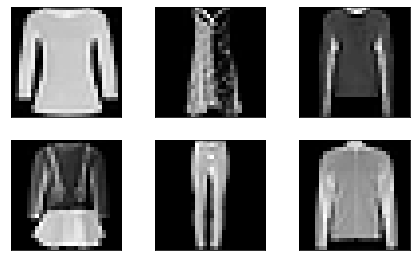

In [16]:
ztest, mutest, logvartest= model.encode(example_data.to(device),example_targets)
test_data=torch.zeros(64,latent_dim)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#     plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [17]:
test_data.shape

torch.Size([64, 25])

In [18]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
fig = plt.Figure()
ax = fig.add_subplot(111)
ax.plot(range(5))
canvas = FigureCanvas(fig)
canvas.print_figure('sample.png')

def plot_examples2(model=None,sample=False,data=None,dim=8):
    if data is None:
        if (model==None):
            batch_idx, (data, example_targets) = next(examples)
        else:
            batch_idx, (data, example_targets) = next(examples)
            if sample:
                zeros=torch.zeros(10,1024)
                samples= torch.cat((torch.rand(32,1024),zeros)).T
                data = model.sample(samples.to(device))
            else:
                data = model(data.to(device),example_targets)[0]
        
    fig = plt.Figure()
#     fig.set_figheight(15)
#     fig.set_figwidth(15)
    for i in range(dim*dim):
        ax = fig.add_subplot(dim,dim,i+1)
        if model:
            plt.imshow(data[i][0].cpu().data, cmap='gray', interpolation='none')
        else:
            plt.imshow(data[i][0], cmap='gray', interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])


def plot_examples(model=None,sample=False,data=None,dim=8):
    if data is None:
        if (model==None):
            batch_idx, (data, example_targets) = next(examples)
        else:
            batch_idx, (data, example_targets) = next(examples)
            if sample:
                zeros=torch.zeros(10,1024)
                samples= torch.cat((torch.rand(32,1024),zeros)).T
                data = model.sample(samples.to(device))
            else:
                data = model(data.to(device),example_targets)[0]
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(dim*dim):
        plt.subplot(dim,dim,i+1)
        plt.tight_layout()
        if model:
            plt.imshow(data[i][0].cpu().data, cmap='gray', interpolation='none')
        else:
            plt.imshow(data[i][0], cmap='gray', interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

In [22]:
ztest[0]

tensor([ 3.3924, -2.1984, -1.6015,  0.7256, -0.5928, -5.2647, -0.4475,  0.0322,
        -2.0350,  0.6058,  1.0340, -1.8226,  1.8191, -1.3930, -2.5674, -1.3785,
         0.4574,  3.1039,  0.9621, -1.7173, -1.9833,  5.2107, -4.1834, -1.7328,
         0.5054], device='cuda:0', grad_fn=<SelectBackward>)

In [40]:
def plot_interpolation(example_data,example_targets,image_n=0,latent_dim=latent_dim,imsize=28,interpolate_dim=20,std_=3):
    ztest, mutest, logvartest= model.encode(example_data.to(device),example_targets)
    test_data=torch.zeros(latent_dim*latent_dim,latent_dim)
    for i in range(test_data.shape[0]):
        test_data[i]=ztest[0]

    range_=np.zeros([latent_dim,interpolate_dim])
    for c,i in enumerate(ztest.std(0).cpu().detach().numpy()):
        range_[c]=np.linspace(std_*i,-std_*i,int(interpolate_dim))

    for c in range(latent_dim*interpolate_dim):
        test_data[c][int(c/latent_dim)]=range_[c%latent_dim][c%interpolate_dim]
    smple_pic =model.sample(test_data.to(device))




    all_pics=np.zeros([imsize*latent_dim,imsize*interpolate_dim])
    for i in range(latent_dim):
        for j in range(interpolate_dim):
    #         print(i,j)
            all_pics[i*imsize:(i+1)*imsize,j*imsize:(j+1)*imsize]=smple_pic[i*j][0].cpu().data
    fig = plt.figure()
    fig.set_figheight(40)
    fig.set_figwidth(20)
    plt.imshow(all_pics, interpolation='none')

plot_interpolation(example_data,example_targets,latent_dim=latent_dim,imsize=28,interpolate_dim=28,std_=100)

IndexError: index 625 is out of bounds for dimension 0 with size 625

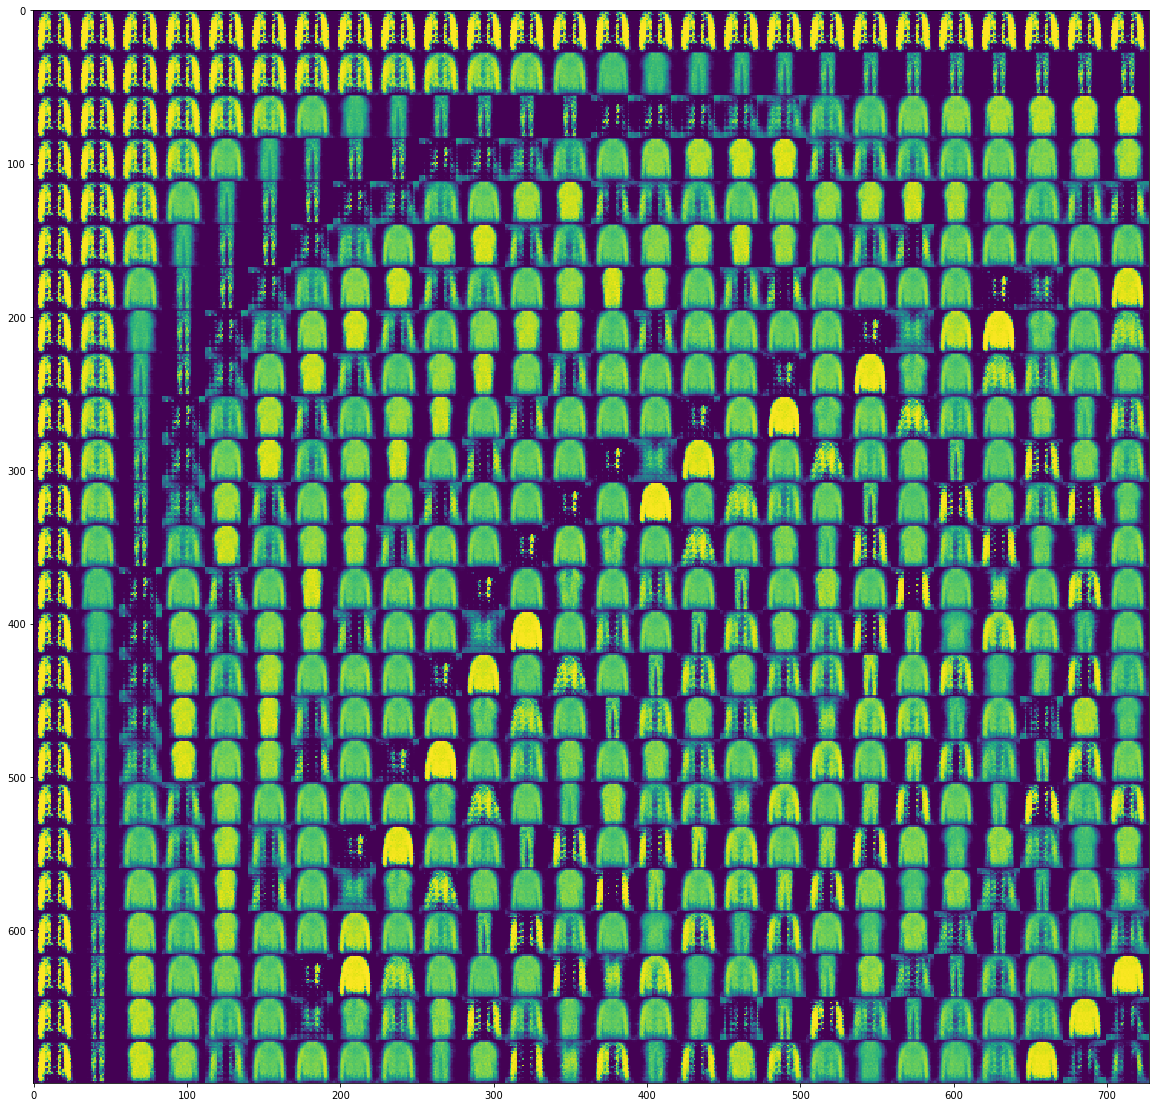

In [91]:
latent_dim=latent_dim
imsize=28
interpolate_dim=26
std_=40

ztest, mutest, logvartest= model.encode(example_data.to(device),example_targets)
test_data=torch.zeros(latent_dim*interpolate_dim,latent_dim)
for i in range(test_data.shape[0]):
    test_data[i]=ztest[0]

range_=np.zeros([latent_dim,interpolate_dim])
for c,i in enumerate(ztest.std(0).cpu().detach().numpy()):
    range_[c]=np.linspace(std_*i,-std_*i,int(interpolate_dim))
    
for c in range(latent_dim*interpolate_dim):
    test_data[c][int(c/interpolate_dim)]=range_[int(c/interpolate_dim)][c%interpolate_dim]
#     print(c,int(c/interpolate_dim),int(c/interpolate_dim),c%interpolate_dim)
smple_pic =model.sample(test_data.to(device))




all_pics=np.zeros([imsize*latent_dim,imsize*interpolate_dim])
for i in range(latent_dim):
    for j in range(interpolate_dim):
#         print(i,j)
        all_pics[i*imsize:(i+1)*imsize,j*imsize:(j+1)*imsize]=smple_pic[i*j][0].cpu().data
fig = plt.figure()
fig.set_figheight(40)
fig.set_figwidth(20)
plt.imshow(all_pics, interpolation='none')

In [84]:
test_data.shape

torch.Size([50, 25])

In [ ]:
# interpolate_dim=20

# test_data=torch.zeros(latent_dim*interpolate_dim,latent_dim)
# for i in range(test_data.shape[0]):
#     test_data[i]=ztest[0]

    
# range_=np.linspace(9,-9,int(interpolate_dim))
# for c in range(latent_dim*interpolate_dim):
#     test_data[c][int(c/latent_dim)]=range_[c%interpolate_dim]
# smple_pic =model.sample(test_data.to(device))
# plot_examples(model=True,data=smple_pic,dim=8)

In [ ]:
def split(example_data,example_targets,samples_per_class,classifier):
    ztest, mutest, logvartest= model.encode(example_data.to(device),example_targets)
    label_n=0
    label_counter=0
    labellist=[]
    for i in range(len(classes)):
        labellist.append(np.where(example_targets.cpu().numpy()==i)[0][:samples_per_class].tolist())
    labellist=np.sort(np.array(labellist).flatten())
    mask = np.ones(example_targets.cpu().numpy().shape,dtype=bool) #np.ones_like(a,dtype=bool)
    mask[labellist] = False
    
    trainKNN_out=example_targets[labellist]
    trainKNN_in=ztest[labellist]
    testKNN_out=example_targets[mask]
    testKNN_in=ztest[mask]
    
    return trainKNN_out,trainKNN_in,testKNN_out,testKNN_in

In [ ]:

def train_classifier(example_data,example_targets,samples_per_class,classifier):
    ztest, mutest, logvartest= model.encode(example_data.to(device),example_targets)
    test_data=torch.zeros(64,8)
    label_n=0
    label_counter=0
    labellist=[]
    for i in range(len(classes)):
        labellist.append(np.where(example_targets.cpu().numpy()==i)[0][:samples_per_class].tolist())
    labellist=np.sort(np.array(labellist).flatten())
    mask = np.ones(example_targets.cpu().numpy().shape,dtype=bool) #np.ones_like(a,dtype=bool)
    mask[labellist] = False
    
    trainKNN_out=example_targets[labellist]
    trainKNN_in=ztest[labellist]
    testKNN_out=example_targets[mask]
    testKNN_in=ztest[mask]
    
    classifier.fit(trainKNN_in.cpu().detach().numpy(), trainKNN_out)
    return classifier,testKNN_out,testKNN_in

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
samples_per_class=10
classifier,testKNN_out,testKNN_in=train_classifier(example_data,example_targets,samples_per_class,neigh)

In [ ]:
def test_classifier(classifier,testKNN_out,testKNN_in):
    error=0
    for test_n in range(len(testKNN_out)):
        exp,real=classifier.predict([testKNN_in.cpu().detach().numpy()[test_n]])[0],testKNN_out[test_n].numpy()
    #     print(exp,real)
        if exp!=real:
            error+=1
    print(error,test_n,error/test_n)
    
test_classifier(classifier,testKNN_out,testKNN_in)

In [ ]:
ztest, mutest, logvartest= model.encode(example_data.to(device),example_targets)
test_data=torch.zeros(64,8)
for i in range(test_data.shape[1]):
    print('max',ztest[:,i].max())
    print('min',ztest[:,i].min())
    print('mean',ztest[:,i].mean())
    print()